# ADS-B data processing

- Authors: Roger Teoh
- Date: 2023-04-18
- `pycontrails`: v0.40.1

Process raw ADS-B data before using in models.

> This functionality will be built into `pycontrails` in [#38](https://github.com/contrailcirrus/pycontrails/pull/38)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/03-ADSB-Processing.ipynb)

In [ ]:
!pip install pycontrails

In [ ]:
# GCP Bucket with sample data
GCP_BUCKET = "gs://2023-04-pycontrails-workshop"

# make data/ directory
!mkdir -p "data/flight/global"

# sync sample flight files
!gsutil -m rsync -r "{GCP_BUCKET}/data/flight/global" "data/flight/global"

In [1]:
import numpy as np
import pandas as pd

In [2]:
adsb = pd.read_parquet("data/flight/global/20200101-raw.pq").drop(columns="flight_uid")
adsb.head()

,timestamp,icao_address,latitude,longitude,collection_type,altitude_baro,speed,callsign,icao_actype,flight_number,tail_number
0,2020-01-01,C00B9E,42.776688,-78.163043,terrestrial,23150.0,310.0,SKV7529,E75S,RS7529,C-FEKJ
1,2020-01-01,89620B,25.140583,55.182201,terrestrial,9175.0,310.0,UAE786,B77W,EK786,A6-EGJ
2,2020-01-01,7809AC,34.212636,133.192463,terrestrial,30000.0,350.0,CQH8506,A320,9C8506,B-6971
3,2020-01-01,AB1496,39.112701,-92.807365,terrestrial,34025.0,370.0,AAL2622,A319,AA2622,N813AW
4,2020-01-01,E49266,-21.986482,-45.475820,terrestrial,31250.0,490.0,GLO1546,B738,G31546,PR-GYD


## Clean

This function removes:

1. Remove messages without data in "icao_address", "aircraft_type_icao",
   "altitude_baro", "on_ground", "tail_number"
2. Ensure columns have the dtype as specified in `MESSAGE_DTYPES`
3. Remove messages with tail number "VARIOUS"
   and aircraft types "N/A", "GNDT", "GRND", "ZZZZ"
5. Remove terrestrial messages without callsign.
   Most of these messages are below 10,000 feet and from general aviation.
7. Drop duplicates by "icao_address" and "timestamp"

In [3]:
# Copy original adsb dataset so it doesn't get mutated
mdf = adsb.copy()
print(len(mdf), "messages")

1810339 messages


In [4]:
# Rename a few fields
mdf.rename(columns={"icao_actype": "aircraft_type_icao"}, inplace=True)

In [5]:
# Remove messages without data in "icao_address", "aircraft_type_icao",
# "altitude_baro", "on_ground", "tail_number"
non_null_cols = [
    "timestamp",
    "longitude",
    "latitude",
    "altitude_baro",
    "icao_address",
    "aircraft_type_icao",
    "tail_number",
]
filt = mdf[non_null_cols].isna().any(axis=1)
mdf = mdf.loc[~filt]

In [6]:
# Ensure columns have the correct dtype
MESSAGE_DTYPES = {
    "icao_address": str,
    "latitude": float,
    "longitude": float,
    "altitude_baro": float,
    "speed": float,
    "callsign": str,
    "tail_number": str,
    "collection_type": str,
    "aircraft_type_icao": str,
}

mdf = mdf.astype(MESSAGE_DTYPES)

In [7]:
# convert timestamp into a timezone naive pd.Timestamp
mdf["timestamp"] = pd.to_datetime(mdf["timestamp"]).dt.tz_localize(None)

In [8]:
# Remove messages with tail number set to VARIOUS
# or aircraft type set to "N/A", "GNDT", "GRND", "ZZZZ"
filt = (mdf["tail_number"] == "VARIOUS") & (
    mdf["aircraft_type_icao"].isin(["N/A", "GNDT", "GRND", "ZZZZ"])
)
mdf = mdf.loc[~filt]

In [9]:
# Remove terrestrial waypoints without callsign
# Most of these waypoints are below 10,000 feet and from general aviation
filt = (mdf["callsign"].isna()) & (mdf["collection_type"] == "terrestrial")
mdf = mdf[~filt]

In [10]:
# Fill missing callsigns for satellite records
callsigns_missing = (mdf["collection_type"] == "satellite") & (mdf["callsign"].isna())
mdf.loc[callsigns_missing, "callsign"] = None  # reset values to be None
for icao_address, gp in mdf.loc[
    mdf["icao_address"].isin(mdf.loc[callsigns_missing, "icao_address"].unique()),
    ["icao_address", "callsign", "collection_type"],
].groupby("icao_address", sort=False):
    mdf.loc[gp.index, "callsign"] = gp["callsign"].fillna(method="ffill").fillna(method="bfill")

In [11]:
# Drop duplicates by icao_address and timestamp
mdf.drop_duplicates(subset=["icao_address", "timestamp"], inplace=True)

In [12]:
# Resest index after filtering
mdf.reset_index(drop=True, inplace=True)
print(len(mdf), "messages")

1810261 messages


## Identify Flights

Simple algorithm:

1. Group by "icao_address", "tail_number", "aircraft_type_icao", "callsign"


In [13]:
def generate_flight_id(time: pd.Timestamp, callsign: str) -> str:
    """Generate a unique flight id for instance of flight.

    Parameters
    ----------
    time : pd.Timestamp
        First waypoint time associated with flight.
    callsign : str
        Callsign of the flight.
        Other flight identifiers could be used if the callsign
        is not defined.

    Returns
    -------
    str
        Flight id in the form "{%Y%m%d-%H%M}-{callsign}"
    """
    t_string = time.strftime("%Y%m%d-%H%M")
    return f"{t_string}-{callsign}"

In [14]:
# Set default flight_id
flight_id = pd.Series(
    data=None,
    dtype=object,
    index=mdf.index,
)

# Group by "icao_address", "tail_number", "aircraft_type_icao", "callsign"
for idx, gp in mdf.groupby(["icao_address", "tail_number", "aircraft_type_icao", "callsign"], sort=False):

    # minimum # of messages
    if len(gp) < 10:
        continue
            
    # save flight ids
    flight_id.loc[gp.index] = generate_flight_id(gp["timestamp"].iloc[0], gp["callsign"].iloc[0])
    
# set series back on dataframe
mdf["flight_id"] = flight_id

In [15]:
# show how many messates per flight
count = mdf[["timestamp", "flight_id"]].groupby("flight_id").count()
count.head()

,timestamp
flight_id,
20200101-0000-AAL100,34
20200101-0000-AAL1011,21
20200101-0000-AAL1018,15
20200101-0000-AAL1045,16
20200101-0000-AAL107,10


## Create `Flight`

In [16]:
from pycontrails import Flight
from pycontrails.physics import units

In [17]:
# select flight
mdf.set_index("flight_id", inplace=True)
fdf = mdf.loc["20200101-0000-AAL100"].reset_index()
fdf.head()

,flight_id,timestamp,icao_address,latitude,longitude,collection_type,altitude_baro,speed,callsign,aircraft_type_icao,flight_number,tail_number
0,20200101-0000-AAL100,2020-01-01 00:00:00,A9D286,40.557380,-73.826065,terrestrial,3175.0,240.0,AAL100,B77W,AA100,N732AN
1,20200101-0000-AAL100,2020-01-01 00:05:05,A9D286,40.835678,-73.561951,terrestrial,14700.0,400.0,AAL100,B77W,AA100,N732AN
2,20200101-0000-AAL100,2020-01-01 00:10:02,A9D286,41.424545,-73.415513,terrestrial,27025.0,450.0,AAL100,B77W,AA100,N732AN
3,20200101-0000-AAL100,2020-01-01 00:15:05,A9D286,42.115677,-73.321318,terrestrial,34325.0,520.0,AAL100,B77W,AA100,N732AN
4,20200101-0000-AAL100,2020-01-01 00:20:05,A9D286,42.615548,-72.562078,terrestrial,35000.0,550.0,AAL100,B77W,AA100,N732AN


In [18]:
# add altitude column
fdf["altitude"] = units.ft_to_m(fdf["altitude_baro"].to_numpy())

# rename timetsamp to "time"
fdf.rename(columns={"timestamp": "time"}, inplace=True)
flight = Flight(data=fdf)

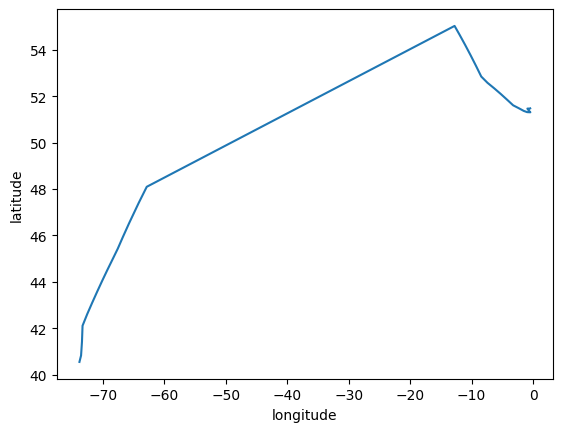

In [19]:
flight.plot();

---

## (In development) Seperate by cruise phase

> Work in progress in [#28](https://github.com/contrailcirrus/pycontrails/pull/38)

Flights with multiple cruise phases are identified by evaluating the
messages between the start and end of the cruise phase.
For these messages that should be at cruise, multiple cruise phases are identified when:

1. Altitudes fall below the minimum cruise altitude.
   This value is set to `MIN_CRUISE_ALTITUDE`.
2. There is a time difference > 15 minutes between messages.

If multiple flights are identified,
the cut-off point is specified at messages with the largest time difference.

Flight "diversion" is defined when the aircraft descends below 10,000 feet
and climbs back to cruise altitude to travel to the alternative airport.
A diversion is identified when all five conditions below are satisfied:

1. Altitude in any messages between
   the start and end of cruise is < `MAX_AIRPORT_ELEVATION` ft
2. Time difference between messages that should be
   at cruise must be < 15 minutes (continuous telemetry)
3. Segment length between messages that should be
   at cruise must be > 500 m (no stationary messages),
4. Time elapsed between message with the lowest altitude
   (during cruise) and final message should be < 2 h,

In [ ]:
from pycontrails.core import flight
from pycontrails.physics import geo, units

In [76]:
def separate_by_cruise_phase(messages: pd.DataFrame) -> pd.Series:

    # Set default flight id
    flight_id = pd.Series(
        data=generate_flight_id(messages["timestamp"].iloc[0], messages["callsign"].iloc[0]),
        dtype=object,
        index=messages.index,
    )

    # Set min cruise altitude
    min_cruise_altitude_ft = 20_000

    # Calculate flight phase
    altitude_ft = messages["altitude_baro"].to_numpy()
    segment_duration = flight.segment_duration(messages["timestamp"].to_numpy())
    segment_rocd = flight.segment_rocd(segment_duration, altitude_ft)
    segment_phase = flight.segment_phase(
        segment_rocd,
        altitude_ft,
        threshold_rocd=250,
        min_cruise_altitude_ft=min_cruise_altitude_ft,
    )

    # get cruise phase
    cruise = segment_phase == flight.FLIGHT_PHASE["cruise"]

    # fill between the first and last cruise phase indicator
    # this represents the flight phase after takeoff climb and before descent to landing
    within_cruise = np.bitwise_xor.accumulate(cruise) | cruise

    # There should not be any waypoints with low altitudes between
    # the start and end of `within_cruise`
    is_low_altitude = altitude_ft < min_cruise_altitude_ft
    is_long_interval = segment_duration > (15 * 60)  # 15 minutes
    anomalous_phase = within_cruise & is_low_altitude & is_long_interval
    multiple_cruise_phase = np.any(anomalous_phase)

    # if there is only one cruise phase, just return one label
    if not multiple_cruise_phase:
        return flight_id

    # Check for presence of a diverted flight
    potentially_diverted = within_cruise & is_low_altitude
    if np.any(potentially_diverted):
        # Calculate segment length
        segment_length = geo.segment_length(
            messages["longitude"].to_numpy(),
            messages["latitude"].to_numpy(),
            units.ft_to_m(altitude_ft),
        )

        # get the index of the minimum altitude when potentially diverted
        altitude_min_diverted = np.min(altitude_ft[potentially_diverted])
        i_lowest_altitude = (
            np.argwhere(within_cruise & is_low_altitude & (altitude_ft == altitude_min_diverted))[
                0
            ][0]
            + 1
        )
        
        # Check for flight diversion
        condition_1 = np.any(altitude_ft[within_cruise] < flight.MAX_AIRPORT_ELEVATION)
        condition_2 = np.all(segment_duration[within_cruise] < (15 * 60))
        condition_3 = np.all(segment_length[within_cruise] > 500)
        condition_4 = np.nansum(segment_duration[i_lowest_altitude:]) < (2 * 60 * 60)

        flight_diversion = condition_1 & condition_2 & condition_3 & condition_4

        # if there is a potential flight diversion, just return a single flight index
        if flight_diversion:
            return flight_id

    # If there are multiple cruise phases, get cut-off point
    i_cutoff = int(np.argmax(segment_duration[anomalous_phase]) + 1)

    # assign a new id after cutoff
    flight_id.iloc[i_cutoff:] = generate_flight_id(
        messages["timestamp"].iloc[i_cutoff], messages["callsign"].iloc[i_cutoff]
    )

In [ ]:
def clean_flight_altitude(
    messages: pd.DataFrame,
    *,
    noise_threshold_ft: float = 25,
    threshold_altitude_ft: float | None = None,
) -> pd.DataFrame:
    """
    Clean erroneous and noisy altitude on a single flight.

    Parameters
    ----------
    messages: pd.DataFrame
        ADS-B messages from a single flight trajectory.
    noise_threshold_ft: float
        Altitude difference threshold to identify noise, [:math:`ft`]
        Barometric altitude from ADS-B telemetry is reported at increments of 25 ft.
    threshold_altitude_ft: float
        Altitude will be checked and corrected above this threshold, [:math:`ft`]
        Currently set to :attr:`flight.MAX_AIRPORT_ELEVATION` ft.

    Returns
    -------
    pd.DataFrame
        ADS-B messages with filtered altitude.

    Notes
    -----
    #. If pycontrails.ext.bada installed,
       remove erroneous altitude, i.e., altitude above operating limit of aircraft type
    #. Remove noise in cruise altitude where flights oscillate
       between 25 ft due to noise in ADS-B telemetry

    See Also
    --------
    :func:`flight.filter_altitude`
    """
    threshold_altitude_ft = threshold_altitude_ft or flight.MAX_AIRPORT_ELEVATION
    mdf = messages.copy()

    # Remove noise in cruise altitude by rounding up/down to the nearest flight level.
    altitude_ft = mdf["altitude_baro"].to_numpy()
    d_alt_ft = np.diff(altitude_ft, prepend=np.nan)
    is_noise = (np.abs(d_alt_ft) <= noise_threshold_ft) & (altitude_ft > threshold_altitude_ft)
    mdf.loc[is_noise, "altitude_baro"] = np.round(altitude_ft[is_noise] / 1000) * 1000

    return mdf